In [1]:
import pandas as pd
url = "https://raw.githubusercontent.com/lmassaron/tabular_datasets/master/AB_TOKYO_summary_listings.csv"
summary_listings = pd.read_csv(url)

In [2]:
summary_listings.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group               float64
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
license                            object
dtype: object

In [3]:
summary_listings['name'].iloc[0]

'Rental unit in Sumida · ★4.78 · 1 bedroom · 2 beds · 1 bath'

In [4]:
# Listing 7.1 Extracting information from text descriptions

import pandas as pd
import re

classification_list = ['aparthotel', 'barn', 'bed and breakfast', 'boutique hotel',
                       'bungalow', 'cabin', 'camper/rv', 'chalet', 'condo', 'cottage',
                       'earthen home', 'farm stay', 'guest suite', 'guesthouse', 'home',
                       'hostel', 'hotel', 'houseboat', 'hut', 'loft', 'place to stay',
                       'rental unit', 'resort', 'ryokan', 'serviced apartment',
                       'tiny home', 'townhouse', 'treehouse', 'vacation home', 'villa']

summary_listings = summary_listings.assign(
    type_of_accommodation=(summary_listings['name']
                           .str.extract(f"({'|'.join(classification_list)})", 
                                        flags=re.IGNORECASE)), #A
    area_of_tokyo=(summary_listings['name']
                   .str.extract(r'in\s(.*?)\s·', 
                                flags=re.IGNORECASE)), #B
    score=(summary_listings['name']
           .str.extract(r'★(\d+\.\d+)', flags=re.IGNORECASE)
           .astype(float)), #C
    number_of_bedrooms=(summary_listings['name']
                        .str.extract(r'(\d+)\s*(?:bedroom|bedrooms)', 
                                     flags=re.IGNORECASE)
                        .fillna(0)
                        .astype(int)), #D
    number_of_beds=(summary_listings['name']
                    .str.extract(r'(\d+)\s+(?:beds?\b)', 
                                 flags=re.IGNORECASE)
                    .fillna(0)
                    .astype(int)), #E
    number_of_baths=(summary_listings['name']
                     .str.extract(r'(?P<baths>\d+)\s*(shared\s+)?(?:half-)?baths?\b', 
                                  flags=re.IGNORECASE)["baths"]
                     .fillna(0)
                     .astype(int)), #F
)

#A extracting the type of accommodation from a list of options
#B extracting the area of Tokyo mentioned in the listing name
#C extracting the rating score from a star symbol followed by a numerical value
#D extracting the number of bedrooms from the listing name
#E extracting the number of beds from the listing name
#F extracting the number of baths from the listing name

In [5]:
# Listing 7.2 Extracting binary flags and time information

import numpy as np
import pandas as pd
from datetime import datetime

summary_listings = summary_listings.assign(
    is_new=(summary_listings['name']
               .str.lower()
               .str.contains('new', case=False)
               .astype(int)), #A
    is_studio=(summary_listings['name']
               .str.lower()
               .str.contains('studio', case=False)
               .astype(int)), #B
    has_shared_bath=(summary_listings['name']
                     .str.lower()
                     .str.contains('shared', case=False)
                     .astype(int)), #C
    has_half_bath=(summary_listings['name']
                   .str.lower()
                   .str.contains('half', case=False)
                   .astype(int)), #D
)

summary_listings['days_since_last_review'] = (datetime.today() - pd.to_datetime(summary_listings['last_review'])).dt.days
summary_listings['days_since_last_review'] = (summary_listings['days_since_last_review'] -   
                                      summary_listings['days_since_last_review'].min()) #E

zero_reviews = summary_listings['number_of_reviews'] == 0
ratio = summary_listings['number_of_reviews_ltm'] / summary_listings['number_of_reviews']
summary_listings['number_of_reviews_ltm_ratio'] = np.where(zero_reviews, 0, ratio) #F

#A checking if the word "new" is present in the name (case-insensitive) 
#B checking if the word "studio" is present in the name (case-insensitive) 
#C checking if the word "shared" is present in the name (case-insensitive)
#D checking if the word "half" is present in the name (case-insensitive) 
#E calculating the number of days between today's date and the 'last_review' date
#F calculating the ratio of "number_of_reviews_ltm" to "number_of_reviews" for each listing

In [6]:
# Listing 7.3  Creating the target from daily listings

url = "https://raw.githubusercontent.com/lmassaron/tabular_datasets/master/AB_TOKYO_calendar.zip"
calendar = pd.read_csv(url)

calendar["adjusted_price"] = calendar["adjusted_price"].apply(lambda x: float(x.replace('$', '').replace(',', ''))) #A

price_stats = (calendar.groupby('listing_id')['adjusted_price'] #B
                       .agg(['mean', 'min', 'max'])) #C

#A removing the dollar sign ('$') and commas (',') from the values and then converting them to float
#B a group by operation on the calendar DataFrame based on the 'listing_id' column
#C calculating three statistics for the 'adjusted_price' column - the mean, minimum, and maximum values

In [7]:
price_stats.head()

,mean,min,max
listing_id,,,
197677,11000.000000,11000.0,11000.0
776070,7208.000000,7208.0,7208.0
905944,24184.243836,23066.0,28833.0
1016831,19383.561644,15000.0,22000.0
1196177,29081.934247,10000.0,33106.0


In [8]:
# Listing 7.4 creating a high cardinality geographical feature

def bin_2_cat(feature, bins=32):
    min_value = feature.min()
    bin_size = (feature.max() - min_value) / bins
    return ((feature - min_value) / bin_size).astype(int) # A
    
summary_listings['coordinates'] = (bin_2_cat(summary_listings['latitude']) * 1000 +   
                                  bin_2_cat(summary_listings['longitude'])) #B

print(summary_listings['coordinates'].nunique())

#A Discretizing the latitude and longitude by bin size
#B Composing the new coordinates feature by summing the discretized latitude and longitude

317


In [9]:
# Listing 7.5 computing a distance metric from the city center

imperial_palace_lat = 35.6841822633
imperial_palace_lon = 139.751471994

def degrees_to_meters(distance_degrees, latitude):
    conversion_factor = 111000 #A
    distance_meters = (distance_degrees * conversion_factor 
                       * np.cos(np.radians(latitude))) #B
    return distance_meters 

distance_degrees = (np.abs(summary_listings['latitude'] - imperial_palace_lat) + 
                    np.abs(summary_listings['longitude'] - imperial_palace_lon)) #C

summary_listings['imperial_palace_distance'] = degrees_to_meters(distance_degrees,  
                                                                 summary_listings['latitude'])

#A conversion factor representing the approximate number of meters per degree of latitude
#B calculating the distance in meters by multiplying the degree-based distance by the conversion factor and adjusting for the latitude's cosine
#C calculating the absolute distance in degrees by subtracting the Imperial palace's latitude and longitude from the values in the dataset 

In [10]:
summary_listings.imperial_palace_distance.mean()

7948.574341001378

In [11]:
(summary_listings[['id', 'name', 'neighbourhood', 'imperial_palace_distance']]
 .iloc[np.argmin(summary_listings['imperial_palace_distance'])])

id                                                         874407512426725982
name                        Home in Shibuya City · ★New · 3 bedrooms · 6 b...
neighbourhood                                                      Chiyoda Ku
imperial_palace_distance                                           137.394271
Name: 10255, dtype: object

In [12]:
# Listing 7.6 Finding the nearest facilities and means of transportation

from sklearn.neighbors import KDTree

url = "https://raw.githubusercontent.com/lmassaron/tabular_datasets/master/relevant_spots_Tokyo.csv"
relevant_spots = pd.read_csv(url)

venue_categories = ['Convenience Store', 'Train Station', 
                    'Airport', 'Bus Station', 'Subway']
min_distances = {'listing_id': summary_listings['id']} #A

for venue in venue_categories:
    venue_filter = relevant_spots['venueCategory'] == venue
    venues = relevant_spots[['latitude', 'longitude']][venue_filter] #B
    tree = KDTree(venues, metric='manhattan') #C
    distance, index = tree.query(summary_listings[['latitude', 'longitude']], k=1) #D
    min_distances['nearest_' + venue.lower().replace(" ", "_")] = degrees_to_meters(
                                 np.ravel(distance), summary_listings['latitude'])
    
min_distances = pd.DataFrame(min_distances) #E

#A storing the minimum distances into a dictionary
#B filtering the relevant venue locations
#C creating a KDTree using the filtered venue locations with the Manhattan metric for fast nearest neighbor searches
#D querying the KDTree to find the nearest point and its distance to each Airbnb listing (k=1 returns the nearest one)
#E the dictionary of the minimum distances for each type of venue is converted into a DataFrame

In [13]:
min_distances.head()

,listing_id,nearest_convenience_store,nearest_train_station,nearest_airport,nearest_bus_station,nearest_subway
0,197677,475.837692,666.488917,8326.122756,829.211343,1733.788985
1,776070,114.974697,384.929313,5430.623850,453.968550,784.313916
2,3427384,410.735809,367.589007,6343.224540,417.734902,422.452055
3,905944,155.409734,268.125319,2929.393383,783.601883,999.752343
4,3514008,160.799573,836.908222,5532.347474,619.141342,781.218689


In [14]:
# Listing 7.7 Assembling data

summary_listings_features = [
    'neighbourhood',
    'coordinates',
    'room_type',
    'minimum_nights', 'number_of_reviews', 'days_since_last_review',
    'reviews_per_month', 'calculated_host_listings_count',
    'availability_365', 'number_of_reviews_ltm', 'number_of_reviews_ltm_ratio',
    'number_of_bedrooms', 'number_of_beds', 'number_of_baths',
    'type_of_accommodation', 'score', 'is_new',
    'is_studio', 'has_shared_bath', 'has_half_bath',
    'imperial_palace_distance'
]

summarized = summary_listings[['id'] + summary_listings_features].rename({'id': 'listing_id'}, axis=1)

X = summarized.merge(min_distances, on='listing_id').set_index('listing_id')

X = X.reindex(price_stats.index) #A
price_stats_ordered = price_stats.reindex(X.index) #B
y = price_stats_ordered['mean'].copy() #C

#A reindexing X to match the index of  price_stats
#B reindexing price_stats to match the index of X, ensuring the reindexed price statistics align with the listings in X
#C copying the 'mean' price column as the target variable

In [15]:
X.head()

,neighbourhood,coordinates,room_type,minimum_nights,number_of_reviews,days_since_last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,...,is_new,is_studio,has_shared_bath,has_half_bath,imperial_palace_distance,nearest_convenience_store,nearest_train_station,nearest_airport,nearest_bus_station,nearest_subway
listing_id,,,,,,,,,,,,,,,,,,,,,
197677,Sumida Ku,20028,Entire home/apt,3,173,30.0,1.21,1,24,8,...,0,0,0,0,9687.728076,475.837692,666.488917,8326.122756,829.211343,1733.788985
776070,Kita Ku,22026,Private room,3,243,9.0,1.89,1,67,15,...,0,0,1,0,6483.053730,114.974697,384.929313,5430.623850,453.968550,784.313916
905944,Shibuya Ku,16022,Entire home/apt,3,186,3.0,1.49,5,229,1,...,0,0,0,0,7069.339820,155.409734,268.125319,2929.393383,783.601883,999.752343
1016831,Setagaya Ku,14022,Private room,1,244,28.0,1.96,1,101,33,...,0,0,1,0,9588.347677,389.067861,377.813210,2914.601177,365.480803,1764.993415
1196177,Adachi Ku,23027,Private room,2,95,1199.0,0.79,1,81,0,...,0,0,1,0,9591.131160,838.151520,243.734144,8538.784439,732.718147,1084.853768


In [16]:
X.isna().sum()

neighbourhood                        0
coordinates                          0
room_type                            0
minimum_nights                       0
number_of_reviews                    0
days_since_last_review            1252
reviews_per_month                 1252
calculated_host_listings_count       0
availability_365                     0
number_of_reviews_ltm                0
number_of_reviews_ltm_ratio          0
number_of_bedrooms                   0
number_of_beds                       0
number_of_baths                      0
type_of_accommodation                0
score                             2381
is_new                               0
is_studio                            0
has_shared_bath                      0
has_half_bath                        0
imperial_palace_distance             0
nearest_convenience_store            0
nearest_train_station                0
nearest_airport                      0
nearest_bus_station                  0
nearest_subway           

In [17]:
(X.number_of_reviews==0).sum()

1252

In [18]:
X[["days_since_last_review", "reviews_per_month", "score"]].describe()

,days_since_last_review,reviews_per_month,score
count,9923.000000,9923.000000,8794.000000
mean,106.513957,1.466074,4.670679
std,268.177531,1.641041,0.279745
min,0.000000,0.020000,2.000000
25%,9.000000,0.550000,4.550000
50%,21.000000,1.060000,4.730000
75%,54.000000,1.930000,4.860000
max,1877.000000,48.640000,5.000000


In [19]:
X.fillna(-1, inplace=True)

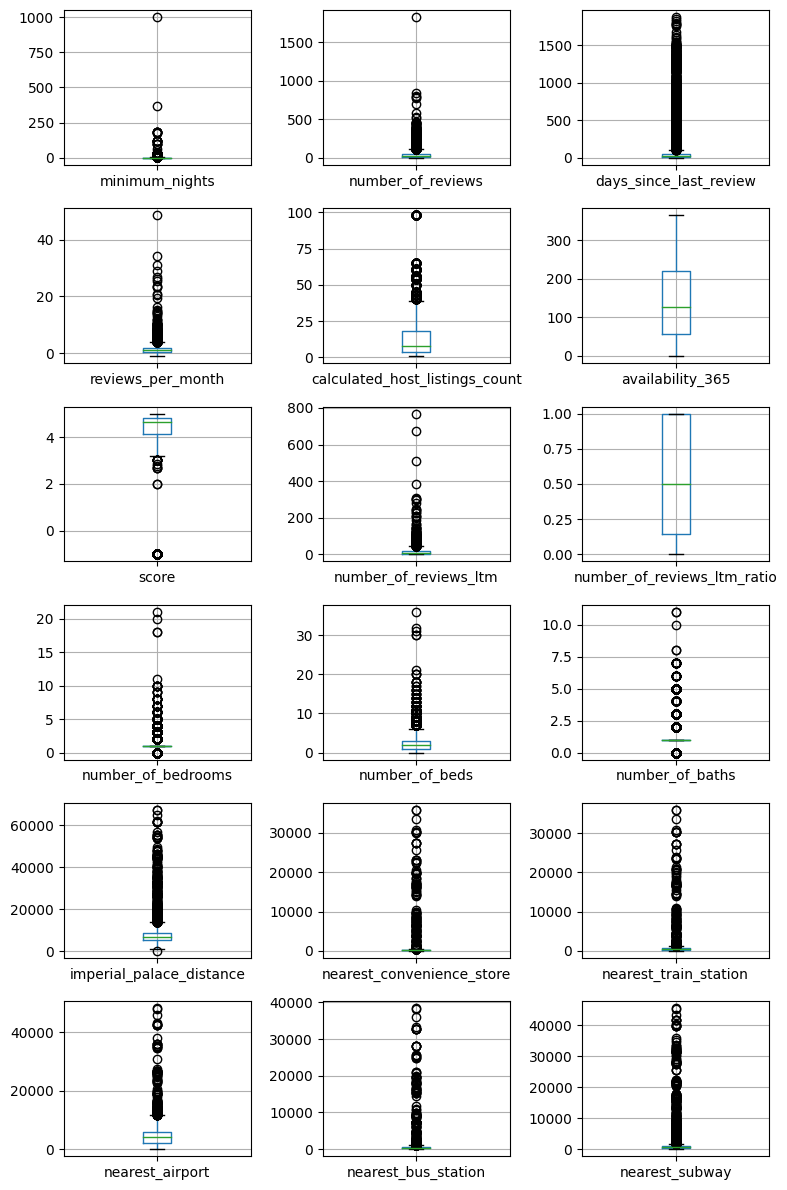

In [20]:
# Listing 7.8 plotting boxplots for numeric features

import matplotlib.pyplot as plt

numeric = ['minimum_nights', 'number_of_reviews', 'days_since_last_review', 'reviews_per_month',
           'calculated_host_listings_count', 'availability_365', 'score', 
           'number_of_reviews_ltm', 'number_of_reviews_ltm_ratio', 'number_of_bedrooms', 
           'number_of_beds', 'number_of_baths', 'imperial_palace_distance', 
           'nearest_convenience_store','nearest_train_station', 'nearest_airport', 
           'nearest_bus_station', 'nearest_subway']

num_plots = len(numeric)
num_rows = (num_plots + 2) // 3 #A
num_cols = min(num_plots, 3) #B

fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 12)) #C
axes = axes.flatten() #D

for i, feat in enumerate(numeric):
    X[[feat]].boxplot(ax=axes[i])

fig.tight_layout()
plt.show()

#A estimating the number of rows needed to arrange subplots
#B calculating the number of columns needed to arrange subplots
#C creating a figure with subplots
#D flattening the axes array to a 1D array so that it can be iterated through

<Axes: >

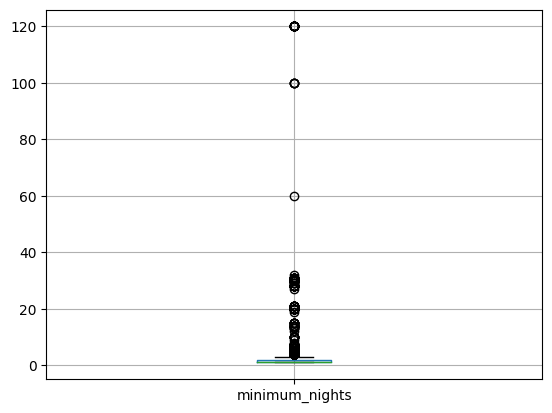

In [21]:
# Listing 7.9 Winsorizing extreme values

from scipy.stats.mstats import winsorize

lower_cut_percentile = 0.00 #A
upper_cut_percentile = 0.001 #B

X['minimum_nights'] = winsorize(X['minimum_nights'].values, 
                                limits=(lower_cut_percentile, upper_cut_percentile))

X[['minimum_nights']].boxplot()

#A indicating the lower percentile below which values will not be changed during winsorization
#B indicating the upper percentile above which values will not be changed during winsorization

<Axes: >

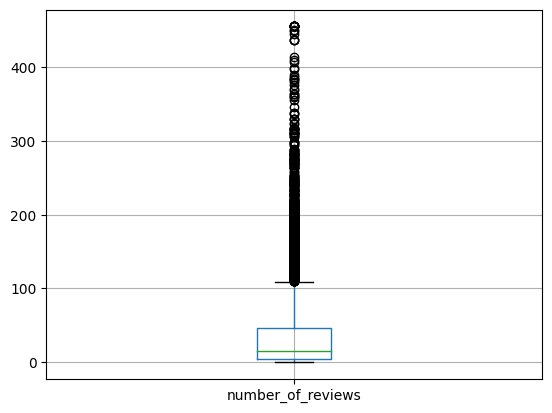

In [22]:
X['number_of_reviews'] = winsorize(X['number_of_reviews'].values,
                                limits=(lower_cut_percentile, upper_cut_percentile))

X[['number_of_reviews']].boxplot()

In [23]:
print(f"minimum: {y.min()}")
print(f"average: {y.mean().round(2)}")
print(f"maximum: {y.max()}")

minimum: 1450.0
average: 36573.1
maximum: 1306500.0


In [24]:
perc = [1, 5, 10, 25, 50, 75, 90, 95, 99]
for p in perc:
    print(f"percentile {p:2}: {np.percentile(y, p).round(2)}")

percentile  1: 3000.0
percentile  5: 5198.02
percentile 10: 7315.67
percentile 25: 11870.07
percentile 50: 19830.78
percentile 75: 37741.64
percentile 90: 83936.03
percentile 95: 84857.11
percentile 99: 304531.4


In [25]:
valid_samples = (y >= 5200) & (y <=84857)

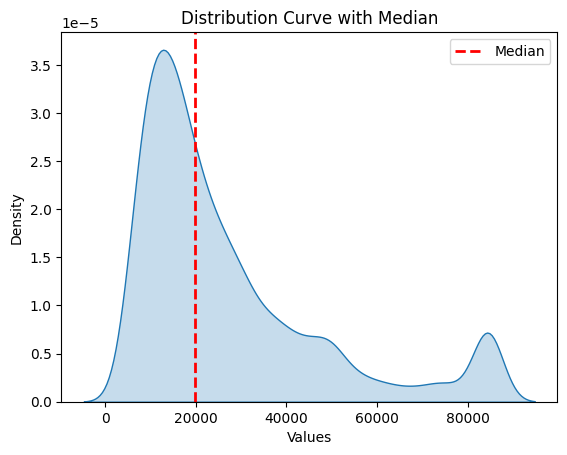

In [26]:
# Listing 7.10 plotting the target distribution

import matplotlib.pyplot as plt
import seaborn as sns

valid_y = y[valid_samples] #A
sns.kdeplot(valid_y, fill=True)

median = np.median(valid_y) #B
plt.axvline(median, color='r', linestyle='--', linewidth=2, label='Median')

plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution Curve with Median')
plt.legend()
plt.show()

#A selecting only the part of the target distribution we consider to model
#B representing the median value of the distribution

In [27]:
X = X[valid_samples]
y = y[valid_samples]

In [28]:
X['neighbourhood'].value_counts()

neighbourhood
Shinjuku Ku            2140
Taito Ku               1464
Sumida Ku              1073
Toshima Ku              932
Shibuya Ku              611
Setagaya Ku             374
Ota Ku                  338
Minato Ku               334
Nakano Ku               296
Kita Ku                 269
Chuo Ku                 268
Suginami Ku             213
Katsushika Ku           211
Koto Ku                 191
Bunkyo Ku               189
Edogawa Ku              178
Arakawa Ku              158
Itabashi Ku             157
Shinagawa Ku            148
Chiyoda Ku              145
Adachi Ku                82
Nerima Ku                61
Meguro Ku                61
Kokubunji Shi            13
Hachioji Shi             13
Fuchu Shi                13
Machida Shi              12
Musashino Shi            11
Akiruno Shi              10
Mitaka Shi               10
Chofu Shi                 9
Koganei Shi               9
Higashimurayama Shi       7
Ome Shi                   7
Komae Shi                 6
Tama S

In [29]:
# Listing 7.11 aggregating nearby neighborhood areas

neighbourhoods = (summary_listings[['neighbourhood', 'latitude', 'longitude']]
           .groupby('neighbourhood')
           .agg({'latitude': 'mean', 'longitude': 'mean', 'neighbourhood': 'count'})) #A

less_than_30 = neighbourhoods[neighbourhoods['neighbourhood'] < 30]
more_than_30 = neighbourhoods[neighbourhoods['neighbourhood'] > 30] #B

kdtree = KDTree(more_than_30[['latitude', 'longitude']]) #C
change_list = {} #D

for i in range(len(less_than_30)):
    row = less_than_30.iloc[[i]]
    _, idx = kdtree.query(row[['latitude', 'longitude']]) #D
    change_list[row.index[0]] = more_than_30.index[idx[0, 0]]

X["neighbourhood_more_than_30"] = X["neighbourhood"].replace(change_list) #F

#A calculating the mean latitude, mean longitude, and the count of listings in each neighborhood
#B separating the neighborhoods into two groups based on the number of listings
#C creating a KDTree using the mean latitude and longitude values of neighbourhoods with counts greater than 30
#D initializing an empty dictionary to store the mappings of the neighborhoods
#E iterating through each neighborhood with counts less than 30 and querying the KDTree to find the nearest neighbourhood with a count greater than 30  
#F replacing the original neighborhood values with the new neighbourhood values based on the mapping in change_list

In [30]:
print(change_list)
print(X["neighbourhood_more_than_30"].value_counts())

{'Akiruno Shi': 'Fuchu Shi', 'Akishima Shi': 'Fuchu Shi', 'Chofu Shi': 'Fuchu Shi', 'Fussa Shi': 'Fuchu Shi', 'Hachioji Shi': 'Fuchu Shi', 'Hamura Shi': 'Fuchu Shi', 'Higashimurayama Shi': 'Fuchu Shi', 'Hino Shi': 'Fuchu Shi', 'Kodaira Shi': 'Fuchu Shi', 'Koganei Shi': 'Fuchu Shi', 'Kokubunji Shi': 'Fuchu Shi', 'Komae Shi': 'Setagaya Ku', 'Kunitachi Shi': 'Fuchu Shi', 'Machida Shi': 'Fuchu Shi', 'Mitaka Shi': 'Suginami Ku', 'Musashimurayama Shi': 'Fuchu Shi', 'Musashino Shi': 'Suginami Ku', 'Nishitokyo Shi': 'Suginami Ku', 'Okutama Machi': 'Fuchu Shi', 'Ome Shi': 'Fuchu Shi', 'Tachikawa Shi': 'Fuchu Shi', 'Tama Shi': 'Fuchu Shi'}
neighbourhood_more_than_30
Shinjuku Ku      2140
Taito Ku         1464
Sumida Ku        1073
Toshima Ku        932
Shibuya Ku        611
Setagaya Ku       380
Ota Ku            338
Minato Ku         334
Nakano Ku         296
Kita Ku           269
Chuo Ku           268
Suginami Ku       237
Katsushika Ku     211
Koto Ku           191
Bunkyo Ku         189
Edoga

In [31]:
# Listing 7.12 defining a stratified strategy

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(5, shuffle=True, random_state=0) #A
cv_splits = cv.split(X, y=X["neighbourhood_more_than_30"]) #B

#A defining a five-fold stratified random splitting
#B generating the cross-validation splits while maintaining the same distribution of neighborhoods with more than 30 listings in each fold

In [32]:
print(cv_splits)

<generator object _BaseKFold.split at 0x7f0647b94f20>


In [33]:
categorical = ['room_type', 'neighbourhood_more_than_30', 'type_of_accommodation', 'coordinates']
numeric = ['minimum_nights', 'number_of_reviews', 'days_since_last_review', 'reviews_per_month',
           'calculated_host_listings_count', 'availability_365', 'score',
           'number_of_reviews_ltm', 'number_of_reviews_ltm_ratio', 'number_of_bedrooms',
           'number_of_beds', 'number_of_baths', 'imperial_palace_distance',
           'nearest_convenience_store','nearest_train_station', 'nearest_airport',
           'nearest_bus_station', 'nearest_subway']
binary = ['is_new', 'is_studio', 'has_shared_bath', 'has_half_bath']

In [34]:
for feat in categorical:
    print(f"{feat} has {X[feat].nunique()} unique values")

room_type has 4 unique values
neighbourhood_more_than_30 has 24 unique values
type_of_accommodation has 29 unique values
coordinates has 296 unique values


In [35]:
onehot_encoding = ['room_type']
ordinal_encoding = ['neighbourhood_more_than_30', 'type_of_accommodation']
target_encoding = ['coordinates']

In [36]:
!pip install category_encoders

In [37]:
# Listing 7.13 defining column transformations

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from category_encoders.target_encoder import TargetEncoder

onehot_encoder = OneHotEncoder(handle_unknown='ignore') #A
ordinal_enconder = OrdinalEncoder(handle_unknown="use_encoded_value", 
                                  unknown_value=np.nan) #B
target_encoder = TargetEncoder(cols=target_encoding, 
                               handle_unknown="value", smoothing=0.5) #C

column_transform = ColumnTransformer(
    [('onehot_encoding', onehot_encoder, onehot_encoding),
     ('ordinal_encoding', ordinal_enconder, ordinal_encoding),
     ('target_encoding', target_encoder, target_encoding),
     ('numeric', 'passthrough', numeric),
     ('binary', 'passthrough', binary)], #D
    remainder='drop', #E
    verbose_feature_names_out=True, #F
    sparse_threshold=0.0) #G

#A creating a One-Hot Encoder object with the option to handle unknown categories by ignoring them during encoding
#B creating an Ordinal Encoder object with handling of unknown categories and the unknown value replaced by np.nan
#C creating a TargetEncoder object, handling unknown values by encoding them using the mean target value and applying smoothing with a parameter of 0.5
#D a Column Transformer object applying the specified encoders to the respective columns
#E dropping remaining columns that are not specified in the transformer 
#F keeping verbose feature names for transformed columns
#G ensuring that the transformed data is kept as dense arrays

In [38]:
Xt = column_transform.fit_transform(X, y)
column_transform.get_feature_names_out()

array(['onehot_encoding__room_type_Entire home/apt',
       'onehot_encoding__room_type_Hotel room',
       'onehot_encoding__room_type_Private room',
       'onehot_encoding__room_type_Shared room',
       'ordinal_encoding__neighbourhood_more_than_30',
       'ordinal_encoding__type_of_accommodation',
       'target_encoding__coordinates', 'numeric__minimum_nights',
       'numeric__number_of_reviews', 'numeric__days_since_last_review',
       'numeric__reviews_per_month',
       'numeric__calculated_host_listings_count',
       'numeric__availability_365', 'numeric__score',
       'numeric__number_of_reviews_ltm',
       'numeric__number_of_reviews_ltm_ratio',
       'numeric__number_of_bedrooms', 'numeric__number_of_beds',
       'numeric__number_of_baths', 'numeric__imperial_palace_distance',
       'numeric__nearest_convenience_store',
       'numeric__nearest_train_station', 'numeric__nearest_airport',
       'numeric__nearest_bus_station', 'numeric__nearest_subway',
       'bin

prediction range: -34929.50241836699 - 136479.6073625742
R-squared: 0.320
RMSE: 17197.323
MAE: 12568.371


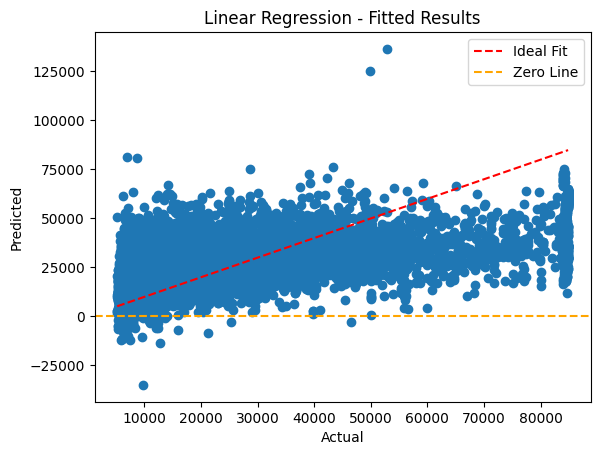

In [39]:
# Listing 7.14 Linear regression baseline model with diagnostic plots

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

lm = LinearRegression(fit_intercept=False) #A
lm.fit(Xt, y) #B

cv_splits = cv.split(X, y=X["neighbourhood_more_than_30"]) #C
y_pred_cv = cross_val_predict(lm, Xt, y, cv=cv_splits) #D

print(f"prediction range: {y_pred_cv.min()} - {y_pred_cv.max()}") #E

r2 = r2_score(y, y_pred_cv)
rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
mae = mean_absolute_error(y, y_pred_cv) #F

print(f'R-squared: {r2:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')

plt.scatter(y, y_pred_cv) #G
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal Fit')
plt.axhline(0, color='orange', linestyle='--', label='Zero Line') # H
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression - Fitted Results')
plt.legend()
plt.show()

#A initializing a LinearRegression model without intercept
#B fitting the LinearRegression model to the transformed training data
#C creating stratified cross-validation splits based on the neighbourhoods with more than 30 counts
#D performing cross-validated predictions
#E printing the range of cross-validated predictions
#F calculating R-squared, RMSE, and MAE evaluation metrics to assess the model's performance
#G creating a scatter plot of actual vs. predicted values
#H plotting a dashed orange zero line to the plot as a reference for the ideal fit

In [40]:
(y_pred_cv <= 0).sum() / len(y_pred_cv)

0.005178767055074196

In [41]:
print(np.where(y_pred_cv > 100_000))

(array([5509, 8307]),)


In [42]:
print(np.where(y_pred_cv < -25_000))

(array([182]),)


In [43]:
# Listing 7.15 inspection of the coefficients

def report_case(model, data, feature_names, case_no):
    case_values = data[case_no] #A
    coef_values = case_values * model.coef_ #B
    for feature_name, value, coef_value in zip(feature_names, case_values, coef_values):
        print(f"{feature_name:50s} ({value:10.2f}) : {coef_value:+0.2f}") #C
    print("-" * 80)
    print(" "*66 + f"{np.sum(coef_values):+0.2f}") #D

#A extracting the feature values for the specified case number from the data array
#B calculating the coefficient values for each feature by multiplying its value with the corresponding coefficient from the model
#C looping and printing through the feature names, their values, and corresponding coefficient values
#D printing the sum of the calculated coefficient values for the case

In [44]:
report_case(model=lm,
            data=Xt,
            feature_names=column_transform.get_feature_names_out(),
            case_no=8307)

onehot_encoding__room_type_Entire home/apt         (      1.00) : -8295.89
onehot_encoding__room_type_Hotel room              (      0.00) : -0.00
onehot_encoding__room_type_Private room            (      0.00) : -0.00
onehot_encoding__room_type_Shared room             (      0.00) : -0.00
ordinal_encoding__neighbourhood_more_than_30       (     12.00) : +576.48
ordinal_encoding__type_of_accommodation            (     20.00) : +2377.99
target_encoding__coordinates                       (  29649.71) : +26556.25
numeric__minimum_nights                            (      1.00) : -268.05
numeric__number_of_reviews                         (      0.00) : -0.00
numeric__days_since_last_review                    (     -1.00) : -0.66
numeric__reviews_per_month                         (     -1.00) : -172.50
numeric__calculated_host_listings_count            (     15.00) : +1470.92
numeric__availability_365                          (    354.00) : +16503.11
numeric__score                           

In [45]:
report_case(model=lm,
            data=Xt,
            feature_names=column_transform.get_feature_names_out(),
            case_no=182)

onehot_encoding__room_type_Entire home/apt         (      0.00) : -0.00
onehot_encoding__room_type_Hotel room              (      0.00) : -0.00
onehot_encoding__room_type_Private room            (      1.00) : -11573.69
onehot_encoding__room_type_Shared room             (      0.00) : -0.00
ordinal_encoding__neighbourhood_more_than_30       (      6.00) : +288.24
ordinal_encoding__type_of_accommodation            (     14.00) : +1664.59
target_encoding__coordinates                       (  27178.66) : +24343.02
numeric__minimum_nights                            (    120.00) : -32166.38
numeric__number_of_reviews                         (    122.00) : -1241.88
numeric__days_since_last_review                    (    132.00) : +87.20
numeric__reviews_per_month                         (      1.33) : +229.43
numeric__calculated_host_listings_count            (      4.00) : +392.25
numeric__availability_365                          (      0.00) : +0.00
numeric__score                         

prediction range: 3291.401123046875 - 123069.8828125
R-squared: 0.693
RMSE: 11562.836
MAE: 7227.435


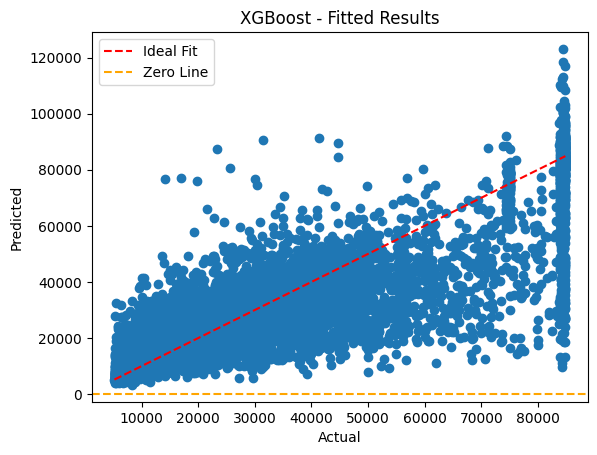

In [46]:
# Listing 7.16 First XGBoost model

from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

xgb = XGBRegressor(booster='gbtree', #A
                   objective='reg:gamma', #B
                   n_estimators=300,
                   max_depth=6)

cv_splits = cv.split(X, y=X["neighbourhood_more_than_30"]) #C
y_pred_cv = cross_val_predict(xgb, Xt, y, cv=cv_splits) #D

print(f"prediction range: {y_pred_cv.min()} - {y_pred_cv.max()}") #E

r2 = r2_score(y, y_pred_cv)
rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
mae = mean_absolute_error(y, y_pred_cv) #F

print(f'R-squared: {r2:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')

plt.scatter(y, y_pred_cv) #G
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal Fit')
plt.axhline(0, color='orange', linestyle='--', label='Zero Line') #H
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGBoost - Fitted Results')
plt.legend()
plt.show()


#A setting up an XGBoost regressor with specific hyperparameters
#B defining 'reg:gamma' as the objective function
#C generating cross-validation splits based on the neighbourhood_more_than_30 feature
#D performing cross-validated predictions
#E printing the range of predicted values
#F calculating R-squared, RMSE, and MAE evaluation metrics to assess the model's performance
#G creating a scatter plot of actual vs. predicted values
#H adding reference lines to the plot for an ideal fit and a zero line

In [47]:
! pip install optuna

In [48]:
# Listing 7.17 optimizing the XGBoost regressor

import optuna

def objective(trial): #A
    
    params = { #B
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear']),
        'objective': trial.suggest_categorical('objective', ['reg:squarederror',
                                                             'reg:gamma',
                                                             'reg:tweedie']),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 100.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 100.0, log=True),
    }
    
    if params['booster'] == 'gblinear': #C
        keys_to_remove = ["colsample_bytree", "max_depth", "min_child_weight", "subsample"]
        params = {key:value for key, value in params.items() if key not in keys_to_remove}
        
    if params['objective'] == 'reg:tweedie': #D
        # Must be between in range [1, 2) - 1=poisson 2=gamma
        params['tweedie_variance_power'] = trial.suggest_float('tweedie_variance_power', 1.01, 1.99)
    
    xgb = XGBRegressor(**params) #E
    model_pipeline = Pipeline([('processing', column_transform), ('xgb', xgb)])
    cv_splits = cv.split(X, y=X["neighbourhood_more_than_30"])

    cv_scores = cross_validate(estimator=model_pipeline, 
                               X=X, 
                               y=y,
                               scoring='neg_mean_absolute_error',
                               cv=cv_splits) #F

    cv_evaluation = np.mean(np.abs(cv_scores['test_score'])) #G
    return cv_evaluation #H

sqlite_db = "sqlite:///sqlite.db"
study_name = "optimize_xgboost_tokyo_airbnb"
study = optuna.create_study(storage=sqlite_db, study_name=study_name, 
                            direction="minimize", load_if_exists=True) #I

study.optimize(objective, n_trials=100) #L
print(study.best_value) #M
print(study.best_params) #N


#A defining an optimization objective function using the Optuna library
#B dictionary containing hyperparameters for optimization, including booster type, objectives, and others
#C adjusting hyperparameters based on the chosen booster type
#D suggesting the additional parameter 'tweedie_variance_power' for a tweedie objective 
#E initializing an XGBoost Regressor with the suggested hyperparameters
#F perform cross-validation using the defined pipeline and optimizing for MAE
#G calculating the mean absolute error (MAE) from the negative MAE scores.
#H return the calculated evaluation metric value to be minimized
#I creating an Optuna study with storage in a SQLite database for optimization
#L performing optimization for a specified number of trials
#M printing the best evaluation metric value achieved during optimization
#N printing the best hyperparameters found during optimization

[I 2023-10-09 22:33:00,490] A new study created in RDB with name: optimize_xgboost_tokyo_airbnb
[I 2023-10-09 22:33:08,093] Trial 0 finished with value: 12731.810961348016 and parameters: {'booster': 'gblinear', 'objective': 'reg:squarederror', 'n_estimators': 925, 'learning_rate': 0.24691751448094806, 'subsample': 0.8597699046235701, 'colsample_bytree': 0.3150074020183003, 'max_depth': 4, 'min_child_weight': 4, 'reg_lambda': 0.001359301207793867, 'reg_alpha': 0.00020283153060282857}. Best is trial 0 with value: 12731.810961348016.
[I 2023-10-09 22:33:13,764] Trial 1 finished with value: 47423.17550500407 and parameters: {'booster': 'gblinear', 'objective': 'reg:tweedie', 'n_estimators': 657, 'learning_rate': 0.01392625266714122, 'subsample': 0.5047149728088067, 'colsample_bytree': 0.8360488804706958, 'max_depth': 2, 'min_child_weight': 3, 'reg_lambda': 1.0946942455078128e-06, 'reg_alpha': 1.622450919769652e-07, 'tweedie_variance_power': 1.8073882445887093}. Best is trial 0 with value:

6670.730179277454
{'booster': 'gbtree', 'objective': 'reg:tweedie', 'n_estimators': 932, 'learning_rate': 0.08588055025922144, 'subsample': 0.9566295202123205, 'colsample_bytree': 0.6730567082779646, 'max_depth': 7, 'min_child_weight': 6, 'reg_lambda': 6.643211493348415e-06, 'reg_alpha': 7.024597970671363e-05, 'tweedie_variance_power': 1.6727891016980427}


In [49]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [50]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()


In [51]:
# Listing 7.18 training the model with full data

best_params = study.best_params
print(best_params)

xgb = XGBRegressor(**best_params) #A
model_pipeline = Pipeline([('processing', column_transform), ('xgb', xgb)])

cv_splits = cv.split(X, y=X["neighbourhood_more_than_30"]) #B

r2_scores = []
rmse_scores = []
mae_scores = []

for train_index, test_index in cv_splits: #C
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)

    r2_scores.append(r2_score(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))

print(f"Mean cv R-squared: {np.mean(r2_scores):.3f}")
print(f"Mean cv RMSE: {np.mean(rmse_scores):.3f}")
print(f"Mean cv MAE: {np.mean(mae_scores):.3f}")

model_pipeline.fit(X, y) #D


#A initializing an XGBoost Regressor using the best hyperparameters obtained from the Optuna study
#B splitting the data using the specified StratifiedKFold strategy
#C iterating through the cross-validation folds to test the model
#D training the final model on the entire dataset

{'booster': 'gbtree', 'objective': 'reg:tweedie', 'n_estimators': 932, 'learning_rate': 0.08588055025922144, 'subsample': 0.9566295202123205, 'colsample_bytree': 0.6730567082779646, 'max_depth': 7, 'min_child_weight': 6, 'reg_lambda': 6.643211493348415e-06, 'reg_alpha': 7.024597970671363e-05, 'tweedie_variance_power': 1.6727891016980427}
Mean cv R-squared: 0.724
Mean cv RMSE: 10944.875
Mean cv MAE: 6670.730


Pipeline(steps=[('processing',
                 ColumnTransformer(sparse_threshold=0.0,
                                   transformers=[('onehot_encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['room_type']),
                                                 ('ordinal_encoding',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['neighbourhood_more_than_30',
                                                   'type_of_accommodation']),
                                                 ('target_encoding',
                                                  TargetEncoder(cols=['coordinat...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.08588055025922144, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=7, max_leaves=None,
                              min_child_weight=6, missing=nan,
                              monotone_constraints=None, n_estimators=932,
                              n_jobs=None, num_parallel_tree=None,
                              objective='reg:tweedie', predictor=None, ...))])

In [52]:
!pip install shap

In [53]:
# Listing 7.19 SHAP values as an XGBoost output

from xgboost import DMatrix

booster = model_pipeline['xgb'].get_booster() #A

Xt = model_pipeline['processing'].transform(X) #B
feature_names = model_pipeline['processing'].get_feature_names_out() #C
Xd = DMatrix(Xt) #D

shap_values = booster.predict(Xd, pred_contribs=True) #E
preds = booster.predict(Xd) #F

#A retrieving the trained XGBoost booster object from the pipeline's trained XGBoost model
#B transforming the input data X using the processing pipeline
#C getting the names of the transformed features after the processing pipeline's transformations
#D creating a DMatrix from the transformed input data
#E calculating SHAP values using the booster's predict function with the pred_contribs=True argument
#F getting the raw predicted values for the input data

In [54]:
np.prod(np.exp(shap_values[0])), preds[0]

(10508.363, 10508.384)

In [55]:
np.corrcoef(preds, np.prod(np.exp(shap_values), axis=1))

array([[1., 1.],
       [1., 1.]])

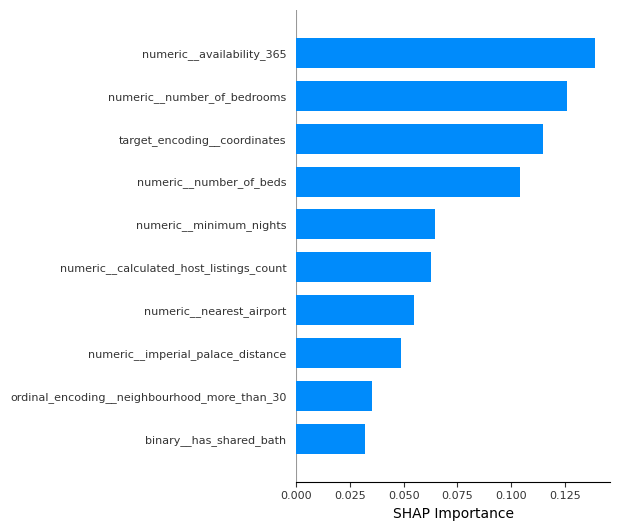

In [56]:
# Listing 7.20 SHAP importance plot

import shap

shap.summary_plot(shap_values[:,:-1], Xt, plot_type="bar", 
                  feature_names=feature_names, max_display=10, show=False) #A
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("SHAP Importance", fontsize=10)
plt.show()

#A generating a summary plot of SHAP feature importance for the top 10 most important features

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


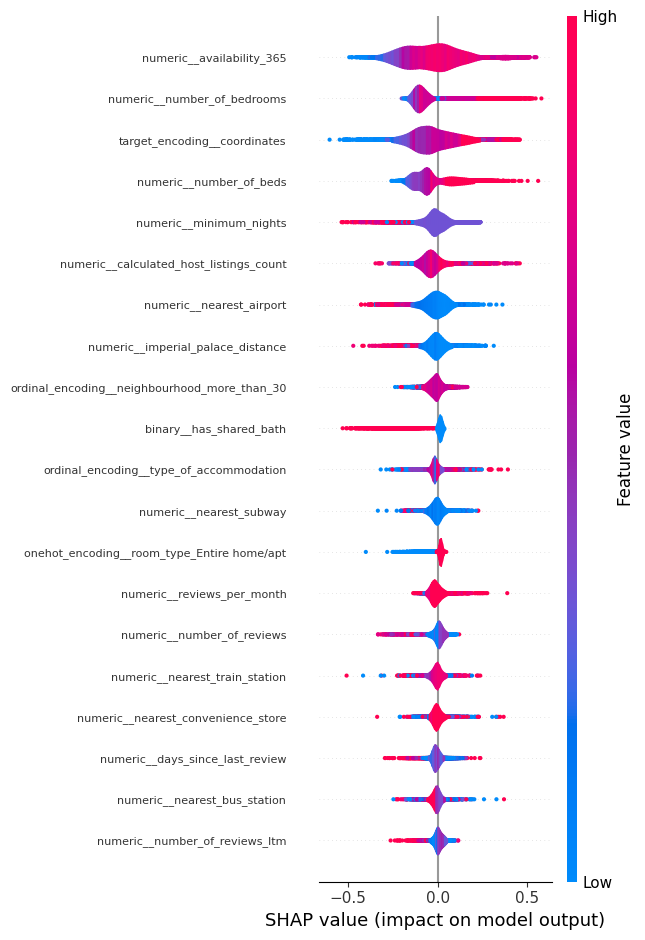

In [57]:
# Listing 7.21 SHAP violin plot

shap.summary_plot(shap_values[:,:-1], Xt,
                  plot_type="violin",
                  feature_names=feature_names, show=False) #A
plt.yticks(fontsize=8)
plt.show()

#A generating a violin plot for the SHAP values